In [228]:
# Импорт библиотек

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [229]:
# Загружаем датасет
df = pd.read_csv('data/train.csv')

# Приводим даты к формату datetime и сортируем
df['dt'] = pd.to_datetime(df['dt'])
df = df.sort_values('dt')

In [230]:
# Добавляем временные признаки
df['year'] = df['dt'].dt.year  # Год
df['month'] = df['dt'].dt.month  # Месяц
df['week_of_year'] = df['dt'].dt.isocalendar().week  # Номер недели
df['quarter'] = df['dt'].dt.quarter  # Квартал

# Сезонные признаки (синус и косинус для месяца)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Создаем лаги и скользящие
for lag in [1, 2, 4, 8, 12]:
    df[f'lag_{lag}'] = df['pfr'].shift(lag)
df['rolling_mean_4'] = df['pfr'].rolling(window=4, min_periods=1).mean()
# Убираем NaN
df.dropna(inplace=True)

# Разделяем данные на train/test
train_size = int(len(df) * 0.80)
train, test = df.iloc[:train_size].copy(), df.iloc[train_size:].copy()

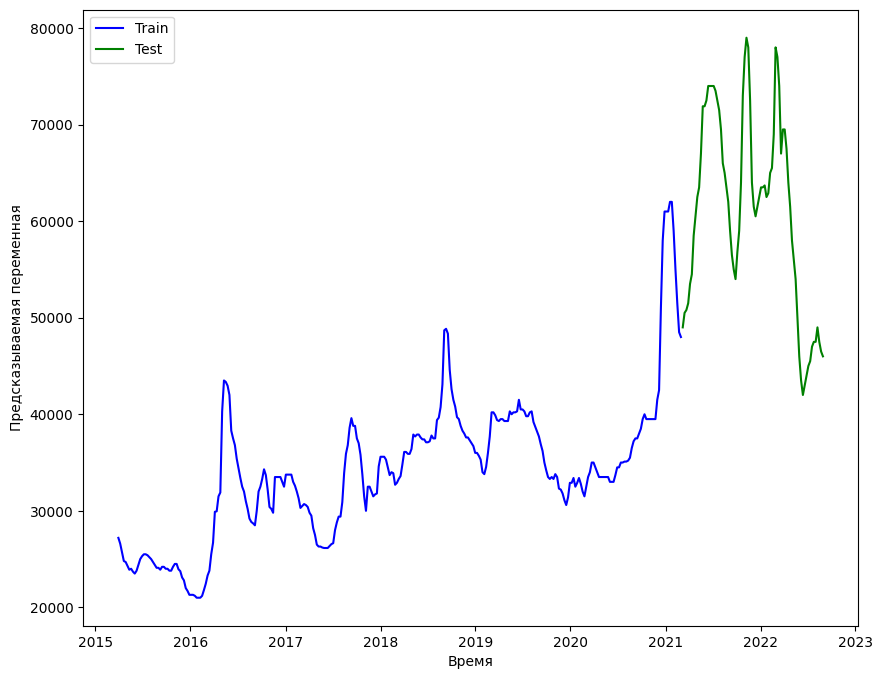

In [231]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(train['dt'], train['pfr'], label='Train', color='blue')
ax.plot(test['dt'], test['pfr'], label='Test', color='green')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.legend()
plt.show()

In [232]:
# Определяем признаки и целевую переменную
features = [col for col in df.columns if 'lag' in col or 'rolling' in col or col in ['year', 'month', 'week_of_year', 'quarter', 'month_sin', 'month_cos']]
X_train, y_train = train[features], train['pfr']
X_test, y_test = test[features], test['pfr']

# Обучаем модель
model = LinearRegression()
model.fit(X_train, y_train)

# Сохраняем модель
joblib.dump(model, 'linear_regression_model.pkl')

['linear_regression_model.pkl']

In [233]:
# Предсказания
predictions = model.predict(X_test)

# Метрики
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
smape = np.mean(2 * np.abs(predictions - y_test) / (np.abs(y_test) + np.abs(predictions))) * 100

# Выводим метрики
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"SMAPE: {smape:.2f}%")

R²: 0.9887
MSE: 1168374.09
RMSE: 1080.91
MAE: 754.00
MAPE: 1.20%
SMAPE: 1.20%


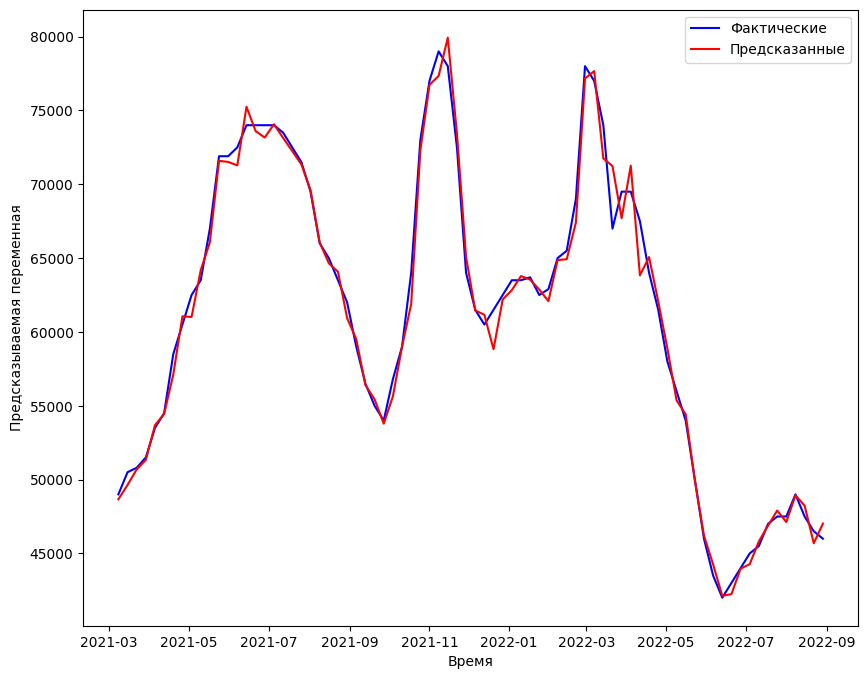

In [234]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(test['dt'], y_test, label='Фактические', color='blue')
ax.plot(test['dt'], predictions, label='Предсказанные', color='red')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.legend()
plt.show()

In [235]:
# Загружаем тестовый датасет
test_df = pd.read_csv('data/test.csv')
test_df['dt'] = pd.to_datetime(test_df['dt'])
test_df = test_df.sort_values('dt')

# Загружаем модель
model = joblib.load('linear_regression_model.pkl')
print("Модель загружена.")

# Создаем временные признаки
test_df['year'] = test_df['dt'].dt.year
test_df['month'] = test_df['dt'].dt.month
test_df['week_of_year'] = test_df['dt'].dt.isocalendar().week
test_df['quarter'] = test_df['dt'].dt.quarter
test_df['month_sin'] = np.sin(2 * np.pi * test_df['month'] / 12)
test_df['month_cos'] = np.cos(2 * np.pi * test_df['month'] / 12)

# Создаем лаги и скользящее среднее
for lag in [1, 2, 4, 8, 12]:
    test_df[f'lag_{lag}'] = test_df['pfr'].shift(lag)
test_df['rolling_mean_4'] = test_df['pfr'].rolling(window=4, min_periods=1).mean()

test_df.dropna(inplace=True)

# Определяем признаки
features = [col for col in test_df.columns if 'lag' in col or 'rolling' in col or col in ['year', 'month', 'week_of_year', 'quarter', 'month_sin', 'month_cos']]
X_test = test_df[features]

# Делаем прогноз
predictions = model.predict(X_test)
test_df['predicted_price'] = predictions

# Определяем N (на сколько недель закупаться)
def calculate_optimal_n(prices, threshold=0.01):
    n_weeks = 1
    for i in range(1, 6):
        if i >= len(prices):
            break
        if prices[i] > prices[0] * (1 + threshold):
            break
        n_weeks += 1
    return n_weeks

test_df['N'] = test_df['predicted_price'].rolling(window=6, min_periods=1).apply(lambda x: calculate_optimal_n(x.values)).astype(int)

# Сохраняем предсказания
test_df[['dt', 'N']].to_excel('test_scored.xlsx', index=False)
print("Результаты сохранены в test_scored.xlsx")


Модель загружена.


KeyError: 'pfr'